# Dataset

In [4]:
import numpy as np
from dataset import Dataset
from visualisation import show_images
%matplotlib inline

### Test load data

File num   : 84
Data size  : 42
Train shape: [42, 128, 128, 1]
Test  shape: [42, 128, 128, 1]
Image shape: [128, 128, 1]

Train images:


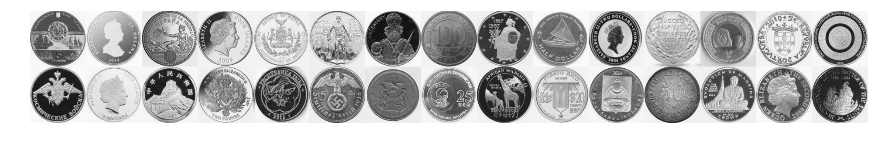

Test images:


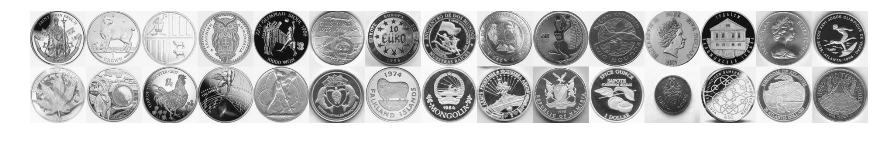

In [5]:
image_shape = [128, 128, 1]
#path        = "/netforge/datasets/private/roman/coins/images"
path        = "/netforge/datasets/private/roman/coins/2017-11-29/images"

data        = Dataset(image_shape)
data_size   = 42

data.load(path, data_size)
train_images, test_images, file_num = data.train_images, data.test_images, data.file_num

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)
print()
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

### Test batching

path     : /netforge/datasets/private/roman/coins/2017-11-29/images
data_size: 100


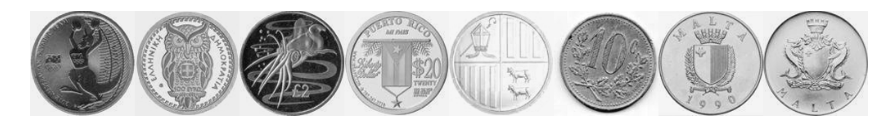

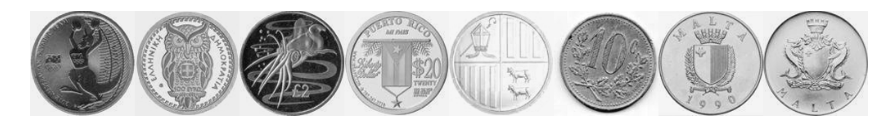

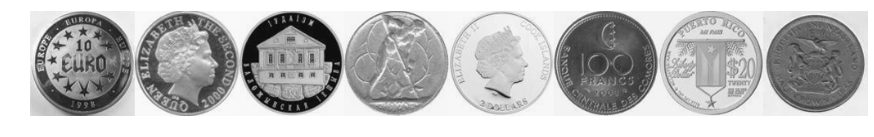

In [3]:
data_size = 100
data = Dataset(image_shape=[128, 128, 1])
data.load(path, data_size)

train_images = data.train_images
image_shape  = data.image_shape

n = 8
im1, im2, im3 = data.get_next_batch(n)
print("path     :", data.path)
print("data_size:", data_size)
show_images(im1, image_shape, cols=n, rows=1)
show_images(im2, image_shape, cols=n, rows=1)
show_images(im3, image_shape, cols=n, rows=1)